# Category classification with Elman RNN and GRU models
22274048, 23191175

First import all necessary modules

In [2]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np
import pandas as pd
import os
from collections import Counter
import string
from argparse import Namespace
import torch.nn as nn
from torch.utils.data import Dataset
import os
import torch.optim as optim
import json
import torch.nn.functional as F
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
from nltk.corpus import stopwords
from argparse import Namespace
import nltk
nltk.download('stopwords')
stopwords = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/omriram/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Get the path to the root directory

In [3]:
script_dir = os.path.dirname(os.path.realpath('__file__'))
script_dir

'/Users/omriram/Desktop/nlp_submission'

Set some non-model related global variables. 

In [4]:
args = Namespace(
    processed_csv = os.path.join(script_dir, 'data/processed_seek.csv'), # path for where to save the processed dataset
    word2vec_model_filepath = os.path.join(script_dir, 'model_storage/word2vec'), # Path for where to save the word2vec model
)

Load the data that has already been processed. Only the job description column needs to be split back into tokens given that the short description column will not be used for this classification task. 

In [5]:
df = pd.read_csv(args.processed_csv)
df.job_description = df.job_description.apply(lambda x: x.split(' ')[:30]) # truncate the job description to improve training speed
df

,category,job_description,job_type_target,short_description,split
0,Trades & Services,"[newcastle, location, car, license, required, ...",Other,advantage lawn regards strictly smoking common...,train
1,"Manufacturing, Transport & Logistics","[beak, johnston, are, industry, leaders, withi...",Full Time,beak within chilled food beak food manufacturi...,train
2,Community Services & Development,"[the, opportunity, do, you, enjoy, challenge, ...",Full Time,young people ymca territory youth community ym...,train
3,Real Estate & Property,"[work, on, one, of, the, best, property, portf...",Full Time,dexus communications funds communications inve...,train
4,Hospitality & Tourism,"[permanent, position, on, offer, for, junior, ...",Full Time,permanent junior sous chef popular tourist des...,train
...,...,...,...,...,...
29650,Information & Communication Technology,"[junior, net, developer, required, for, start,...",Other,net start start youa tmll net development deve...,test
29651,Trades & Services,"[we, are, seeking, general, labourers, hands, ...",Other,general labourers hands various assignments as...,test
29652,Sales,"[no, industry, experience, no, worries, use, y...",Other,industry people face face industry youa tmre p...,test
29653,Construction,"[this, large, building, construction, firm, ar...",Full Time,sydeny cbd new builder developer yearsa needle...,test


### Defining some helper classes

These classes are needed for preparing the vocabularhy and dataset to be fed as batches when training the models. Their utility was covered in the lab and the job_type notebook. 

In [9]:
class Vocabulary(object):
    """Class to process text and extract Vocabulary for mapping"""
    def __init__(self, token_to_idx=None, add_unk=True, unk_token="<UNK>"):
        """
        Args:
            token_to_idx (dict): a pre-existingmap of tokens to indices
            add_unk (bool): a flag that indicates whether to add the UNK token
            unk_token (str): the UNK token to add into the Vocabulary
        """
        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx
        self._idx_to_token = {idx: token 
                                for token, idx in self._token_to_idx.items()}
        self._add_unk = add_unk
        self._unk_token = unk_token
        self.unk_index = 1
        if add_unk:
            self.unk_index = self.add_token(unk_token)
    def to_serializable(self):
        """ returns a dictionary that can be serialized """
        return {'token_to_idx': self._token_to_idx,
                'add_unk': self._add_unk,
                'unk_token': self._unk_token}
    @classmethod
    def from_serializable(cls, contents):
        """ instantiates the Vocabulary from a serialized dictionary """
        return cls(**contents)
    def add_token(self, token):
        """Update mapping dicts based on the token.
        Args:
            token (str): the item to add into the Vocabulary
        Returns:
            index (int): the integer corresponding to the token
        """
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
    
    def add_many(self, tokens):
        """Add a list of tokens into the Vocabulary
        
        Args:
            tokens (list): a list of string tokens
        Returns:
            indices (list): a list of indices corresponding to the tokens
        """
        return [self.add_token(token) for token in tokens]
    
    def lookup_token(self, token):
        """Retrieve the index associated with the token
        or the UNK index if token isn't present.
        Args:
            token (str): the token to look up
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary)
            for the UNK functionality
        """
        if self._add_unk:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]
    def lookup_index(self, index):
        """Return the token associated with the index
        Args:
            index (int): the index to look up
        Returns:
            token (str): the token corresponding to the index
        Raises:
        KeyError: if the index is not in the Vocabulary
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]
    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)
    def __len__(self):
        return len(self._token_to_idx)

In [10]:
class SequenceVocabulary(Vocabulary):
    def __init__(self, token_to_idx=None, unk_token="<UNK>",
                 mask_token="<MASK>", begin_seq_token="<BEGIN>",
                 end_seq_token="<END>"):

        super(SequenceVocabulary, self).__init__(token_to_idx)

        self._mask_token = mask_token
        self._unk_token = unk_token
        self._begin_seq_token = begin_seq_token
        self._end_seq_token = end_seq_token

        self.mask_index = self.add_token(self._mask_token)
        self.unk_index = self.add_token(self._unk_token)
        self.begin_seq_index = self.add_token(self._begin_seq_token)
        self.end_seq_index = self.add_token(self._end_seq_token)

    def to_serializable(self):
        contents = super(SequenceVocabulary, self).to_serializable()
        contents.update({'unk_token': self._unk_token,
                         'mask_token': self._mask_token,
                         'begin_seq_token': self._begin_seq_token,
                         'end_seq_token': self._end_seq_token})
        return contents

    def lookup_token(self, token):
        """Retrieve the index associated with the token 
          or the UNK index if token isn't present.
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary) 
              for the UNK functionality 
        """
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

In [11]:
class Vectorizer(object):
    """ The Vectorizer which coordinates the Vocabularies and puts them to use"""    
    def __init__(self, desc_vocab, target_vocab):
        self.description_vocab = desc_vocab
        self.target_vocab = target_vocab
    def vectorize(self, description, vector_length=-1):
        """
        Args:
            description (list) : tokenized description 
            vector_length (int): an argument for forcing the length of index vector
        Returns:
            the vetorized description (numpy.array)
        """
        indices = []
        
        
        indices.extend(self.description_vocab.lookup_token(token) 
                       for token in description)
        if vector_length < 0:
            vector_length = len(indices)
        
        out_vector = np.zeros(vector_length, dtype=np.int64)
     
        out_vector[:len(indices)] = indices
       

        return out_vector
    
    def vectorize_one_hot(self, description):
        """Create a collapsed one hot vector for the job description
        Args:
            description_tokenized (list): the tokenized job description
        Returns:
            one_hot (np.ndarray): the collapsed onehot encoding
        """
        one_hot = np.zeros(len(self.description_vocab), dtype=np.float32)
        for token in description:
            if token not in string.punctuation:
                one_hot[self.description_vocab.lookup_token(token)] = 1
        return one_hot
    
    @classmethod
    def from_dataframe(cls, df, feature_column = 'short_description', target_cat = False, cutoff=10):
        """Instantiate the vectorizer from the dataset dataframe
        Args:
            description_df (pandas.DataFrame): the target dataset
            cutoff (int): frequency threshold for including in Vocabulary 
        Returns:
            an instance of the descriptionVectorizer
        """
        target_vocab = Vocabulary(add_unk=False)
        if target_cat:
            for target in sorted(set(df.category)):
                target_vocab.add_token(target)    
        else:
            for job_type in sorted(set(df.job_type_target)):
                target_vocab.add_token(job_type)
        
 
        word_counts = Counter()
        for desc in df[feature_column]:
            desc = desc.split(' ') if type(desc) is not list else desc
            for token in desc:
                word_counts[token] += 1

        desc_vocab = SequenceVocabulary()
        for word, word_count in word_counts.items():
            if word_count >= cutoff:
                desc_vocab.add_token(word)
        
        return cls(desc_vocab, target_vocab)

    @classmethod
    def from_serializable(cls, contents):
        description_vocab = \
            SequenceVocabulary.from_serializable(contents['description_vocab'])
        target_vocab =  \
            Vocabulary.from_serializable(contents['target_vocab'])

        return cls(description_vocab=description_vocab, target_vocab=target_vocab)

    def to_serializable(self):
        return {'description_vocab': self.description_vocab.to_serializable(),
                'target_vocab': self.target_vocab.to_serializable()}

In [12]:
class Dataset(Dataset):
    def __init__(self, df, vectorizer, short = True, job_type = True, one_hot = False):
        """
        Args:
            df (pandas.DataFrame): the dataset
            vectorizer (GloveVectorizer): vectorizer instatiated from dataset
        """
        self.one_hot = one_hot
        self.df = df
        self._vectorizer = vectorizer
        self.short = short
        self.job_type = job_type

        # +1 if only using begin_seq, +2 if using both begin and end seq tokens
        measure_len = lambda context: len(context)
        if self.short:
            self._max_seq_length = max(map(measure_len, df.short_description)) + 2
        else:
            self._max_seq_length = max(map(measure_len, df.job_description)) + 2
        
        self.train_df = self.df[self.df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.df[self.df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df = self.df[self.df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.validation_size),
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')

        # Class weights
        if self.job_type:
            class_counts = df.job_type_target.value_counts().to_dict()
        else:
            class_counts = df.category.value_counts().to_dict()
        def sort_key(item):
            return self._vectorizer.target_vocab.lookup_token(item[0])
        

        sorted_counts = sorted(class_counts.items(), key=sort_key)
        frequencies = [count for _, count in sorted_counts]
        self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32)
        
        
    @classmethod
    def load_df_and_make_vectorizer(cls, df, short = True, one_hot = False, job_type =False):
        """Load dataset and make a  vectorizer from scratch
        
        Args:
            csv (str): location of the dataset
        Returns:
            an instance of Dataset
        """
        train_df = df[df.split=='train']
        return cls(df, Vectorizer.from_dataframe(train_df, target_cat=not job_type), 
                   short = short, one_hot = one_hot, job_type = job_type)

    @staticmethod
    def load_vectorizer_only(vectorizer_filepath):
        """a static method for loading the vectorizer from file
        
        Args:
            vectorizer_filepath (str): the location of the serialized vectorizer
        Returns:
            an instance of GloveVectorizer
        """
        with open(vectorizer_filepath) as fp:
            return Vectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        """saves the vectorizer to disk using json
        
        Args:
            vectorizer_filepath (str): the location to save the vectorizer
        """
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self._vectorizer.to_serializable(), fp)

    def get_vectorizer(self):
        """ returns the vectorizer """
        return self._vectorizer

    def set_split(self, split="train"):
        """ selects the splits in the dataset using a column in the dataframe """
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """the primary entry point method for PyTorch datasets
        
        Args:
            index (int): the index to the data point 
        Returns:
            a dictionary holding the data point's features (x_data) and label (y_target)
        """
        row = self._target_df.iloc[index]
        if self.one_hot:
            if self.short:
                description_vector = \
                    self._vectorizer.vectorize_one_hot(row.short_description)
            else:
                description_vector = \
                    self._vectorizer.vectorize_one_hot(row.job_description)

        else:
            if self.short:
                description_vector = \
                    self._vectorizer.vectorize(row.short_description, self._max_seq_length)
            else:
                description_vector = \
                    self._vectorizer.vectorize(row.job_description, self._max_seq_length)

        if self.job_type:
            target_index = \
                self._vectorizer.target_vocab.lookup_token(row.job_type_target)
        else:
            target_index = \
                self._vectorizer.target_vocab.lookup_token(row.category)


        return {'x_data': description_vector,
                'y_target': target_index}

    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset
        
        Args:
            batch_size (int)
        Returns:
            number of batches in the dataset
        """ 
        return len(self) // batch_size

### Defining some helper functions

In [7]:
def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"): 
    """
    A generator function which wraps the PyTorch DataLoader. It will 
      ensure each tensor is on the write device location.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}

def update_train_state(args, model, train_state):
    """Handle the training state updates.

    Components:
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better

    :param args: main arguments
    :param model: model to train
    :param train_state: a dictionary representing the training state values
    :returns:
        a new train_state
    """

    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]

        # If loss worsened
        if loss_t >= train_state['early_stopping_best_val']:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])

            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

def compute_accuracy(y_pred, y_target):
    _, y_pred_indices = y_pred.max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

def compute_accuracy_BCE(y_pred, y_target):
    y_target = y_target.cpu()
    y_pred_indices = (torch.sigmoid(y_pred)>0.5).cpu().long()#.max(dim=1)[1]
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

In [8]:
def train_model(classifier, dataset, args,loss_func, BCE = False, one_hot = False):
    """
    args:
    classifier: the pytorch model that will be trained.
    dataset: An object from the dataset class
    returns:
    the classifier and the final trainstate
    """
    classifier = classifier.to(args.device)
    dataset.class_weights = dataset.class_weights.to(args.device)
    
    
    optimizer = optim.Adam(classifier.parameters(), lr = args.learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode = 'min', factor=0.5, patience=1)

    train_state = make_train_state(args)

    epoch_bar = tqdm(desc='training routine', 
                            total=args.num_epochs,
                            position=0)

    dataset.set_split('train')
    train_bar = tqdm(desc='split=train',
                            total=dataset.get_num_batches(args.batch_size), 
                            position=1, 
                            leave=True)
    dataset.set_split('val')
    val_bar = tqdm(desc='split=val',
                          total=dataset.get_num_batches(args.batch_size), 
                          position=1, 
                          leave=True)


    classifier.float() # sets classifier to receive in double precision format
    try:
        
        for epoch in range(args.num_epochs):
            train_state['epoch_index'] = epoch
            dataset.set_split('train')
            batch_generator = generate_batches(dataset, batch_size=args.batch_size, device=args.device)

            running_loss = 0.0
            running_acc = 0.0
            classifier.train()

            for batch_index, batch_dict in enumerate(batch_generator):
                optimizer.zero_grad()
                if BCE and one_hot:
                    
                    y_pred = classifier(batch_dict['x_data'].float())
                    loss = loss_func(y_pred, batch_dict['y_target'].float())
                if BCE and not one_hot:
                    y_pred = classifier(batch_dict['x_data'])
                    loss = loss_func(y_pred, batch_dict['y_target'].float())
                else:
                    y_pred = classifier(batch_dict['x_data'])
                    loss = loss_func(y_pred, batch_dict['y_target'])
                loss_t = loss.item()
                running_loss += (loss_t - running_loss) / (batch_index + 1)
                loss.backward()
                optimizer.step()
                if BCE:
                    acc_t = compute_accuracy_BCE(y_pred, batch_dict['y_target'])
                else:
                    acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
                running_acc += (acc_t  - running_acc)/(batch_index+1)
                #update bar
                train_bar.set_postfix(loss=running_loss, acc=running_acc, 
                                      epoch=epoch)
                train_bar.update()

            train_state['train_loss'].append(running_loss)
            train_state['train_acc'].append(running_acc)

            dataset.set_split('val')
            batch_generator = generate_batches(dataset, batch_size=args.batch_size, device=args.device)
            running_loss = 0.
            running_acc = 0.
            classifier.eval()

            for batch_index, batch_dict in enumerate(batch_generator):
                
                # step 3. compute the loss
                if BCE and one_hot:
                    
                    y_pred = classifier(batch_dict['x_data'].float())
                    loss = loss_func(y_pred, batch_dict['y_target'].float())
                elif BCE and not one_hot:
                    y_pred = classifier(batch_dict['x_data'])
                    loss = loss_func(y_pred, batch_dict['y_target'].float())
                else:
                    y_pred = classifier(batch_dict['x_data'])
                    loss = loss_func(y_pred, batch_dict['y_target'])
               
                loss_t = loss.item()
                running_loss += (loss_t - running_loss) / (batch_index + 1)
                if BCE:
                     acc_t = compute_accuracy_BCE(y_pred, batch_dict['y_target'])
                else:
                    acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
                running_acc += (acc_t - running_acc) / (batch_index + 1)
                val_bar.set_postfix(loss=running_loss, acc=running_acc, 
                                  epoch=epoch)
                val_bar.update()
            train_state['val_loss'].append(running_loss)
            train_state['val_acc'].append(running_acc)

            train_state = update_train_state(args=args, model=classifier,
                                          train_state=train_state)

            scheduler.step(train_state['val_loss'][-1])

            if train_state['stop_early']:
                break
            train_bar.n = 0
            val_bar.n = 0
            epoch_bar.update()


    except KeyboardInterrupt:
        print("Exiting loop")
    return classifier, train_state

def test_model( classifier, dataset, train_state, args,
               loss_func, BCE=False, one_hot = False):
    dataset.set_split('test')
    batch_generator = generate_batches(dataset, 
                                       batch_size=args.batch_size, 
                                       device=args.device)
    running_loss = 0.
    running_acc = 0.
    classifier.eval()

    for batch_index, batch_dict in enumerate(batch_generator):
        # compute the output
        if BCE and one_hot:
                    
            y_pred = classifier(batch_dict['x_data'].float())
            loss = loss_func(y_pred, batch_dict['y_target'].float())
        elif BCE and not one_hot:
            y_pred = classifier(batch_dict['x_data'])
            loss = loss_func(y_pred, batch_dict['y_target'].float())
        else:
            y_pred = classifier(batch_dict['x_data'])
            loss = loss_func(y_pred, batch_dict['y_target'])
               
        loss_t = loss.item()
        running_loss += (loss_t - running_loss) / (batch_index + 1)

    # compute the accuracy
        if BCE:
            acc_t = compute_accuracy_BCE(y_pred, batch_dict['y_target'])
        else:
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
        running_acc += (acc_t - running_acc) / (batch_index + 1)

    train_state['test_loss'] = running_loss
    train_state['test_acc'] = running_acc
    print("Test loss: {};".format(train_state['test_loss']))
    print("Test Accuracy: {}".format(train_state['test_acc']))

In [13]:
def make_embedding_matrix(embeddings, word_to_idx, words):
    """
    Create embedding matrix for a specific set of words.
    
    Args:
        glove_filepath (str): file path to the glove embeddigns
        words (list): list of words in the dataset
    """
    embedding_size = embeddings.shape[1]
    
    final_embeddings = np.zeros((len(words), embedding_size))

    for i, word in enumerate(words):
        if word in word_to_idx:
            final_embeddings[i, :] = embeddings[word_to_idx[word]]
        else:
            embedding_i = torch.ones(1, embedding_size)
            torch.nn.init.xavier_uniform_(embedding_i)
            final_embeddings[i, :] = embedding_i

    return final_embeddings

In [14]:
def column_gather(y_out, x_lengths):
    '''Get a specific vector from each batch datapoint in `y_out`.

    More precisely, iterate over batch row indices, get the vector that's at
    the position indicated by the corresponding value in `x_lengths` at the row
    index.

    Args:
        y_out (torch.FloatTensor, torch.cuda.FloatTensor)
            shape: (batch, sequence, feature)
        x_lengths (torch.LongTensor, torch.cuda.LongTensor)
            shape: (batch,)

    Returns:
        y_out (torch.FloatTensor, torch.cuda.FloatTensor)
            shape: (batch, feature)
    '''
    x_lengths = x_lengths.long().detach().cpu().numpy() - 1

    out = []
    for batch_index, column_index in enumerate(x_lengths):
        out.append(y_out[batch_index, column_index])

    return torch.stack(out)

### Prepare the dataset, dataloader and the vectors

Initializing some classes and deriving the vectorizer from the dataset

In [15]:
dataset = Dataset.load_df_and_make_vectorizer(df, short=False, job_type=False)
vectorizer = dataset.get_vectorizer()
words = vectorizer.description_vocab._token_to_idx.keys()

Load the domain specific word2vec and glove models then derive their respective embedding matrix. 

In [21]:
def load_embedding_model():
    """ Load GloVe Vectors
        Return:
            wv_from_bin: All 400000 embeddings, each lengh 200
    """
    import gensim.downloader as api
    wv_pretrained = api.load("glove-wiki-gigaword-100")
    print("The loaded object is of type %s" % str(type(wv_pretrained)))
    return wv_pretrained
glove_model = load_embedding_model()
glove_model = glove_model
glove_model

The loaded object is of type <class 'gensim.models.keyedvectors.KeyedVectors'>


In [30]:
word2idx = {word: idx for idx, word in enumerate(glove_model.index_to_key)}
glove_embeddings = make_embedding_matrix(
    embeddings=glove_model.vectors,
    word_to_idx=word2idx,
    words = words
)
glove_embeddings

array([[ 0.17425895,  0.13701704, -0.09837696, ..., -0.10546444,
        -0.02548973, -0.06699389],
       [ 0.13849902, -0.17438376,  0.09362206, ..., -0.1916936 ,
         0.04483265,  0.05267736],
       [-0.0398777 ,  0.23137239,  0.06928661, ..., -0.06379534,
         0.14641485,  0.17183077],
       ...,
       [-0.05440985, -0.18250073, -0.11589241, ..., -0.13082072,
        -0.12286809, -0.2297201 ],
       [ 0.14612818, -0.01021323,  0.07447088, ..., -0.16200161,
         0.143839  , -0.1802195 ],
       [ 0.04568   ,  0.58192003, -0.10553   , ...,  0.44628   ,
        -0.11492   , -0.38626   ]])

In [31]:
word2vec_model = Word2Vec.load(args.word2vec_model_filepath).wv
word2vec_model

Now that the two vector models have been loaded their embedding matrix can be derived

In [32]:
word2idx = {word: idx for idx, word in enumerate(word2vec_model.index_to_key)}
word2vec_embeddings = make_embedding_matrix(embeddings=word2vec_model.vectors, word_to_idx=word2idx, words=words)
word2vec_embeddings

array([[ 0.19473317,  0.14353439,  0.01408815, ..., -0.14886162,
         0.02190417,  0.03260687],
       [ 0.15891233,  0.1954425 , -0.13688608, ...,  0.0347704 ,
         0.07194573, -0.23589656],
       [ 0.0115827 , -0.03519228,  0.03942406, ..., -0.04594985,
         0.04210159,  0.20509943],
       ...,
       [ 2.15021205, -6.7816577 , -1.96817946, ..., -1.24320638,
        -2.86503792, -2.08244395],
       [-1.27098382,  0.59809715,  1.94900548, ..., -2.42886901,
         2.58384299,  0.44639191],
       [-0.90105385, -3.58310127, -1.63292301, ..., -1.35538149,
        -2.43408036, -1.92034709]])

### Vanilla RNN classifier

Below RNN architecture taken from the unit's lab

In [17]:
class RNNLayer(nn.Module):
    """ an Elman RNN built using the RNNCell """
    def __init__(self, input_size, hidden_size, batch_first=False, vanilla = True):
        """
        Args:
            input_size (int): size of the input vectors
            hidden_size (int): size of the hidden state vectors
            bathc_first (bool): whether the 0th dimension is batch
        """
        super(RNNLayer, self).__init__()
        
        if vanilla:
            self.rnn_cell = nn.RNNCell(input_size, hidden_size)
        else:
            self.rnn_cell = nn.GRUCell(input_size, hidden_size)
        
        self.batch_first = batch_first
        self.hidden_size = hidden_size

    def _initial_hidden(self, batch_size):
        return torch.zeros((batch_size, self.hidden_size))

    def forward(self, x_in, initial_hidden=None):
        """The forward pass of the ElmanRNN
        
        Args:
            x_in (torch.Tensor): an input data tensor. 
                If self.batch_first: x_in.shape = (batch, seq_size, feat_size)
                Else: x_in.shape = (seq_size, batch, feat_size)
            initial_hidden (torch.Tensor): the initial hidden state for the RNN
        Returns:
            hiddens (torch.Tensor): The outputs of the RNN at each time step. 
                If self.batch_first: hiddens.shape = (batch, seq_size, hidden_size)
                Else: hiddens.shape = (seq_size, batch, hidden_size)
        """
        if self.batch_first:
            batch_size, seq_size, feat_size = x_in.size()
            x_in = x_in.permute(1, 0, 2)
        else:
            seq_size, batch_size, feat_size = x_in.size()
    
        hiddens = []

        if initial_hidden is None:
            initial_hidden = self._initial_hidden(batch_size)
            initial_hidden = initial_hidden.to(x_in.device)

        hidden_t = initial_hidden
                    
        for t in range(seq_size):
            hidden_t = self.rnn_cell(x_in[t], hidden_t)
            hiddens.append(hidden_t)
            
        hiddens = torch.stack(hiddens)

        if self.batch_first:
            hiddens = hiddens.permute(1, 0, 2)

        return hiddens


class rnnClassifier(nn.Module):
    """ A Classifier with an RNN to extract features and an MLP to classify """
    def __init__(self, embedding_size, num_embeddings, num_classes,
                 rnn_hidden_size, batch_first=True, padding_idx=0, pretrained_embeddings=None, vanilla = True):
        """
        Args:
            embedding_size (int): The size of the character embeddings
            num_embeddings (int): The number of characters to embed
            num_classes (int): The size of the prediction vector 
                Note: the number of nationalities
            rnn_hidden_size (int): The size of the RNN's hidden state
            batch_first (bool): Informs whether the input tensors will 
                have batch or the sequence on the 0th dimension
            padding_idx (int): The index for the tensor padding; 
                see torch.nn.Embedding
        """
        super(rnnClassifier, self).__init__()

        if pretrained_embeddings is None:

            self.emb = nn.Embedding(embedding_dim=embedding_size,
                                    num_embeddings=num_embeddings
                                    )        
        else:
            pretrained_embeddings = torch.from_numpy(pretrained_embeddings).float()
            self.emb = nn.Embedding(embedding_dim=embedding_size,
                                    num_embeddings=num_embeddings,
                                    _weight=pretrained_embeddings)
        self.rnn = RNNLayer(input_size=embedding_size,
                             hidden_size=rnn_hidden_size,
                             batch_first=batch_first, vanilla = vanilla)
        self.fc1 = nn.Linear(in_features=rnn_hidden_size,
                         out_features=rnn_hidden_size)
        self.fc2 = nn.Linear(in_features=rnn_hidden_size,
                          out_features=num_classes)

    def forward(self, x_in, x_lengths=None, apply_softmax=False):
        """The forward pass of the classifier
        
        Args:
            x_in (torch.Tensor): an input data tensor. 
                x_in.shape should be (batch, input_dim)
            x_lengths (torch.Tensor): the lengths of each sequence in the batch.
                They are used to find the final vector of each sequence
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, output_dim)
        """
        x_embedded = self.emb(x_in)
        y_out = self.rnn(x_embedded)

        if x_lengths is not None:
            y_out = column_gather(y_out, x_lengths)
        else:
            y_out = y_out[:, -1, :]

        y_out = F.relu(self.fc1(F.dropout(y_out, 0.5)))
        y_out = self.fc2(F.dropout(y_out, 0.5))

        if apply_softmax:
            y_out = F.softmax(y_out, dim=1)

        return y_out

#### Classification using the domain specific embeddings

In [18]:
rnn_args = Namespace(
    # Model hyper parameters 
    hidden_dim=100, 
    embedding_dim = 100, # only relevant for glove and trained word2vec
    num_classes = len(df['category'].unique()),
    # Training hyper parameter
    seed=1337, 
    learning_rate=0.001, 
    batch_size=128,
    dropout_p=0.5, 
    num_epochs=100, 
    early_stopping_criteria=3, 
    # Runtime option
    cuda=True, 
    catch_keyboard_interrupt=True, 
    expand_filepaths_to_save_dir=True,
    save_dir= script_dir + '/model_storage/rnn/',
    model_state_file="rnn_model.pth",
) 
# Check CUDA
if not torch.cuda.is_available():
    rnn_args.cuda = False
    
rnn_args.device = torch.device("cuda" if rnn_args.cuda else "cpu")
print("Using CUDA: {}".format(rnn_args.cuda))

Using CUDA: False


In [35]:
rnn_args.model_state_file = script_dir + '/model_storage/rnn/rnn_word2vec.pth'

In [36]:
rnn_classifier_word2vec = rnnClassifier(embedding_size=rnn_args.embedding_dim, 
                            num_embeddings=len(vectorizer.description_vocab),
                                        num_classes=rnn_args.num_classes,
                            rnn_hidden_size=rnn_args.hidden_dim, 
                            pretrained_embeddings=word2vec_embeddings)
rnn_classifier_word2vec, rnn_word2vec_train_state = train_model(classifier=rnn_classifier_word2vec,
                                                      dataset=dataset, args = rnn_args,
                                                     loss_func=nn.CrossEntropyLoss())
rnn_classifier_word2vec

training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/162 [00:00<?, ?it/s]

split=val:   0%|          | 0/23 [00:00<?, ?it/s]

Exiting loop


rnnClassifier(
  (emb): Embedding(6764, 100)
  (rnn): RNNLayer(
    (rnn_cell): RNNCell(100, 100)
  )
  (fc1): Linear(in_features=100, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=30, bias=True)
)

#### Classification using the pretrained glove embeddings

In [37]:
rnn_args.model_state_file = script_dir + '/model_storage/rnn/rnn_glove.pth'

In [38]:
rnn_args.model_state_file = script_dir + '/model_storage/rnn/rnn_glove.pth'
rnn_classifier_glove = rnnClassifier(embedding_size=rnn_args.embedding_dim, 
                            num_embeddings=len(vectorizer.description_vocab),
                                        num_classes=rnn_args.num_classes,
                            rnn_hidden_size=rnn_args.hidden_dim, 
                            pretrained_embeddings=word2vec_embeddings)
rnn_classifier_glove, rnn_glove_train_state = train_model(classifier=rnn_classifier_glove,
                                                      dataset=dataset, args = rnn_args,
                                                     loss_func=nn.CrossEntropyLoss())
rnn_classifier_glove

training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/162 [00:00<?, ?it/s]

split=val:   0%|          | 0/23 [00:00<?, ?it/s]

Exiting loop


rnnClassifier(
  (emb): Embedding(6764, 100)
  (rnn): RNNLayer(
    (rnn_cell): RNNCell(100, 100)
  )
  (fc1): Linear(in_features=100, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=30, bias=True)
)

In [39]:
test_model( rnn_classifier_glove, dataset,
            rnn_glove_train_state, rnn_args,
          nn.CrossEntropyLoss())

Test loss: 2.504289818846661;
Test Accuracy: 28.957201086956527


### GRU RNN model

#### Gru classifier trained with domain specific word2vec embeddings

In [40]:
rnn_args.model_state_file = script_dir + '/model_storage/rnn/gru_word2vec.pth'

In [41]:
gru_classifier_word2vec = rnnClassifier(embedding_size=rnn_args.embedding_dim, 
                            num_embeddings=len(vectorizer.description_vocab),
                                        num_classes=rnn_args.num_classes,
                            rnn_hidden_size=rnn_args.hidden_dim, 
                            pretrained_embeddings=word2vec_embeddings, vanilla=False)
gru_classifier_word2vec, gru_word2vec_train_state = train_model(classifier=gru_classifier_word2vec,
                                                      dataset=dataset, args = rnn_args,
                                                     loss_func=nn.CrossEntropyLoss())
gru_classifier_word2vec

training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/162 [00:00<?, ?it/s]

split=val:   0%|          | 0/23 [00:00<?, ?it/s]

Exiting loop


rnnClassifier(
  (emb): Embedding(6764, 100)
  (rnn): RNNLayer(
    (rnn_cell): GRUCell(100, 100)
  )
  (fc1): Linear(in_features=100, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=30, bias=True)
)

In [42]:
test_model(gru_classifier_word2vec, dataset,
            rnn_glove_train_state, rnn_args,
          nn.CrossEntropyLoss())

Test loss: 1.7946090698242188;
Test Accuracy: 56.02921195652175


#### Gru classifier trained with pretrained glove embeddings

In [43]:
rnn_args.model_state_file = script_dir + '/model_storage/rnn/gru_glove.pth'

In [44]:
rnn_args.model_state_file = script_dir + '/model_storage/rnn/gru_glove.pth'
gru_classifier_glove = rnnClassifier(embedding_size=rnn_args.embedding_dim, 
                            num_embeddings=len(vectorizer.description_vocab),
                                        num_classes=rnn_args.num_classes,
                            rnn_hidden_size=rnn_args.hidden_dim, 
                            pretrained_embeddings=glove_embeddings, vanilla=False)
gru_classifier_glove, gru_glove_train_state = train_model(classifier=gru_classifier_glove,
                                                      dataset=dataset, args = rnn_args,
                                                     loss_func=nn.CrossEntropyLoss())
gru_classifier_glove

training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/162 [00:00<?, ?it/s]

split=val:   0%|          | 0/23 [00:00<?, ?it/s]

Exiting loop


rnnClassifier(
  (emb): Embedding(6764, 100)
  (rnn): RNNLayer(
    (rnn_cell): GRUCell(100, 100)
  )
  (fc1): Linear(in_features=100, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=30, bias=True)
)

In [45]:
test_model(gru_classifier_glove, dataset,
           gru_glove_train_state, rnn_args,
          nn.CrossEntropyLoss())

Test loss: 2.010760364325151;
Test Accuracy: 44.2764945652174


## Model Evalution

In [19]:
def evaluation( classifier, dataset, args,num_classes,
                binary=False):
    """
    args:
        classifier to evaluate,
        dataset: test data for evaluating the classifier,
        train_state: the final train state after training the model,
        BCE: whether to use binary cross entrop or cross entropy,
    returns:
        
        
    """
   
    
    from torchmetrics import ConfusionMatrix, F1Score,Precision,Accuracy,Recall
    confmat = ConfusionMatrix(num_classes=num_classes)
    
    import numpy
    fin_mat = numpy.zeros((num_classes,num_classes))
    
    dataset.set_split('test')
    batch_generator = generate_batches(dataset, 
                                       batch_size=args.batch_size, device = rnn_args.device
                                       )
    y_pred = None
    y_true = None
    classifier.eval()

    for batch_index, batch_dict in enumerate(batch_generator):
        # compute the output
        inputs, labels = batch_dict
        if binary:
                    
            output = classifier(batch_dict['x_data'].float())
            
        else:
            output = classifier(batch_dict['x_data'])

        
        if y_pred is None:
            y_pred = output
            y_true = batch_dict['y_target'].data
        else:
            y_pred = torch.cat((y_pred, output))
            y_true = torch.cat((y_true, batch_dict['y_target']))
        
        fin_mat += confmat(output.data.cpu(), batch_dict['y_target'].data.cpu()).numpy()
    if binary:
        recall = Recall()
        f1Score = F1Score()
        accuracy = Accuracy()
        precision = Precision()
    else:
        recall = Recall(num_classes=num_classes, average="weighted")
        f1Score = F1Score(num_classes=num_classes, average="weighted")
        accuracy = Accuracy(num_classes=num_classes, average="weighted")
        precision = Precision(num_classes=num_classes, average="weighted")
    classification_report = {"Recall": recall(y_pred.data.cpu(), y_true.data.cpu()).numpy(),
                            "F1Score": f1Score(y_pred.data.cpu(), y_true.data.cpu()).numpy(),
                             "Accuracy": accuracy(y_pred.data.cpu(), y_true.data.cpu()).numpy(),
                             "Precision": precision(y_pred.data.cpu(), y_true.data.cpu()).numpy()
                            }
    return classification_report, fin_mat

#### Load models

In [ ]:
rnn_args.model_state_file = script_dir + '/model_storage/rnn/gru_glove.pth'
gru_classifier_glove = rnnClassifier(embedding_size=rnn_args.embedding_dim, 
                            num_embeddings=len(vectorizer.description_vocab),
                                        num_classes=rnn_args.num_classes,
                            rnn_hidden_size=rnn_args.hidden_dim, 
                            pretrained_embeddings=glove_embeddings, vanilla=False)
gru_classifier_glove.load_state_dict(torch.load(rnn_args.model_state_file))

rnn_args.model_state_file = script_dir + '/model_storage/rnn/gru_word2vec.pth'
gru_classifier_word2vec = rnnClassifier(embedding_size=rnn_args.embedding_dim, 
                            num_embeddings=len(vectorizer.description_vocab),
                                        num_classes=rnn_args.num_classes,
                            rnn_hidden_size=rnn_args.hidden_dim, 
                            pretrained_embeddings=word2vec_embeddings, vanilla=False)

gru_classifier_word2vec.load_state_dict(torch.load(rnn_args.model_state_file))

rnn_args.model_state_file = script_dir + '/model_storage/rnn/rnn_glove.pth'
rnn_classifier_glove = rnnClassifier(embedding_size=rnn_args.embedding_dim, 
                            num_embeddings=len(vectorizer.description_vocab),
                                        num_classes=rnn_args.num_classes,
                            rnn_hidden_size=rnn_args.hidden_dim, 
                            pretrained_embeddings=word2vec_embeddings)

rnn_classifier_glove.load_state_dict(torch.load(rnn_args.model_state_file))


# rnn_args.model_state_file = script_dir + '/model_storage/rnn/rnn_word2vec.pth'
# rnn_classifier_word2vec = rnnClassifier(embedding_size=rnn_args.embedding_dim, 
#                             num_embeddings=len(vectorizer.description_vocab),
#                                         num_classes=rnn_args.num_classes,
#                             rnn_hidden_size=rnn_args.hidden_dim, 
#                             pretrained_embeddings=word2vec_embeddings)
# rnn_classifier_word2vec.load_state_dict(torch.load(rnn_args.model_state_file))

In [49]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.8/409.8 KB 7.9 MB/s eta 0:00:0000:01


In [50]:
gru_glove_report, gru_glove_conf_mat=evaluation( gru_classifier_glove, dataset, rnn_args,30,
                binary=False)

In [51]:
gru_word2vec_report, gru_word2vec_conf_mat=evaluation( gru_classifier_word2vec, dataset, rnn_args,30,
                binary=False)


In [52]:
rnn_glove_report, rnn_glove_conf_mat=evaluation( rnn_classifier_glove, dataset, rnn_args,30,
                binary=False)

In [53]:
rnn_word2vec_report, rnn_word2vec_conf_mat=evaluation( rnn_classifier_word2vec, dataset, rnn_args,30,
                binary=False)

In [54]:
print("{:<10} {:<20} {:<20} {:<20} {:<20}".format('key', 'GRU GLOVE', 'GRU WORD2VEC', 'RNN GLOVE', 'RNN WORD2VEC'))
for key in gru_glove_report.keys():
    
    print ("{:<5} {:<10} {:<10} {:<10} {:<10}".format(key,gru_glove_report[key], gru_word2vec_report[key], 
                                               rnn_glove_report[key], rnn_word2vec_report[key]))

key        GRU GLOVE            GRU WORD2VEC         RNN GLOVE            RNN WORD2VEC        
Recall 0.421025812625885 0.5602921843528748 0.28872284293174744 0.2967051863670349
F1Score 0.3672293722629547 0.544337272644043 0.1837371587753296 0.21396441757678986
Accuracy 0.421025812625885 0.5602921843528748 0.28872284293174744 0.2967051863670349
Precision 0.3639560341835022 0.5385403633117676 0.15161021053791046 0.18773514032363892


On all accounts the GRU model using the domain specific word to vec embedding outperforms all other combinations. This is closely followed by the GRU model using glove embedding. Thus, Generally, the GRU model is better than the RNN model, this is an expected result since the GRU is more complex and has a property that allows it to keep add weights to information from it older hidden state and, hence, draw out more semantic information for the classification.
Additionally, the domain specific word to vec embedding outperforms the Pretrained  word embedding. This was also expected since domain spefic words tend to have altererd meanings and thus vectorisation when compared to genereic words.

## Confusion Matrices

In [55]:
classnames = []
for i in range(30):
    classnames.append( dataset._vectorizer.target_vocab.lookup_index(i))

Text(0.5, 1.0, 'RNN GLOVE')

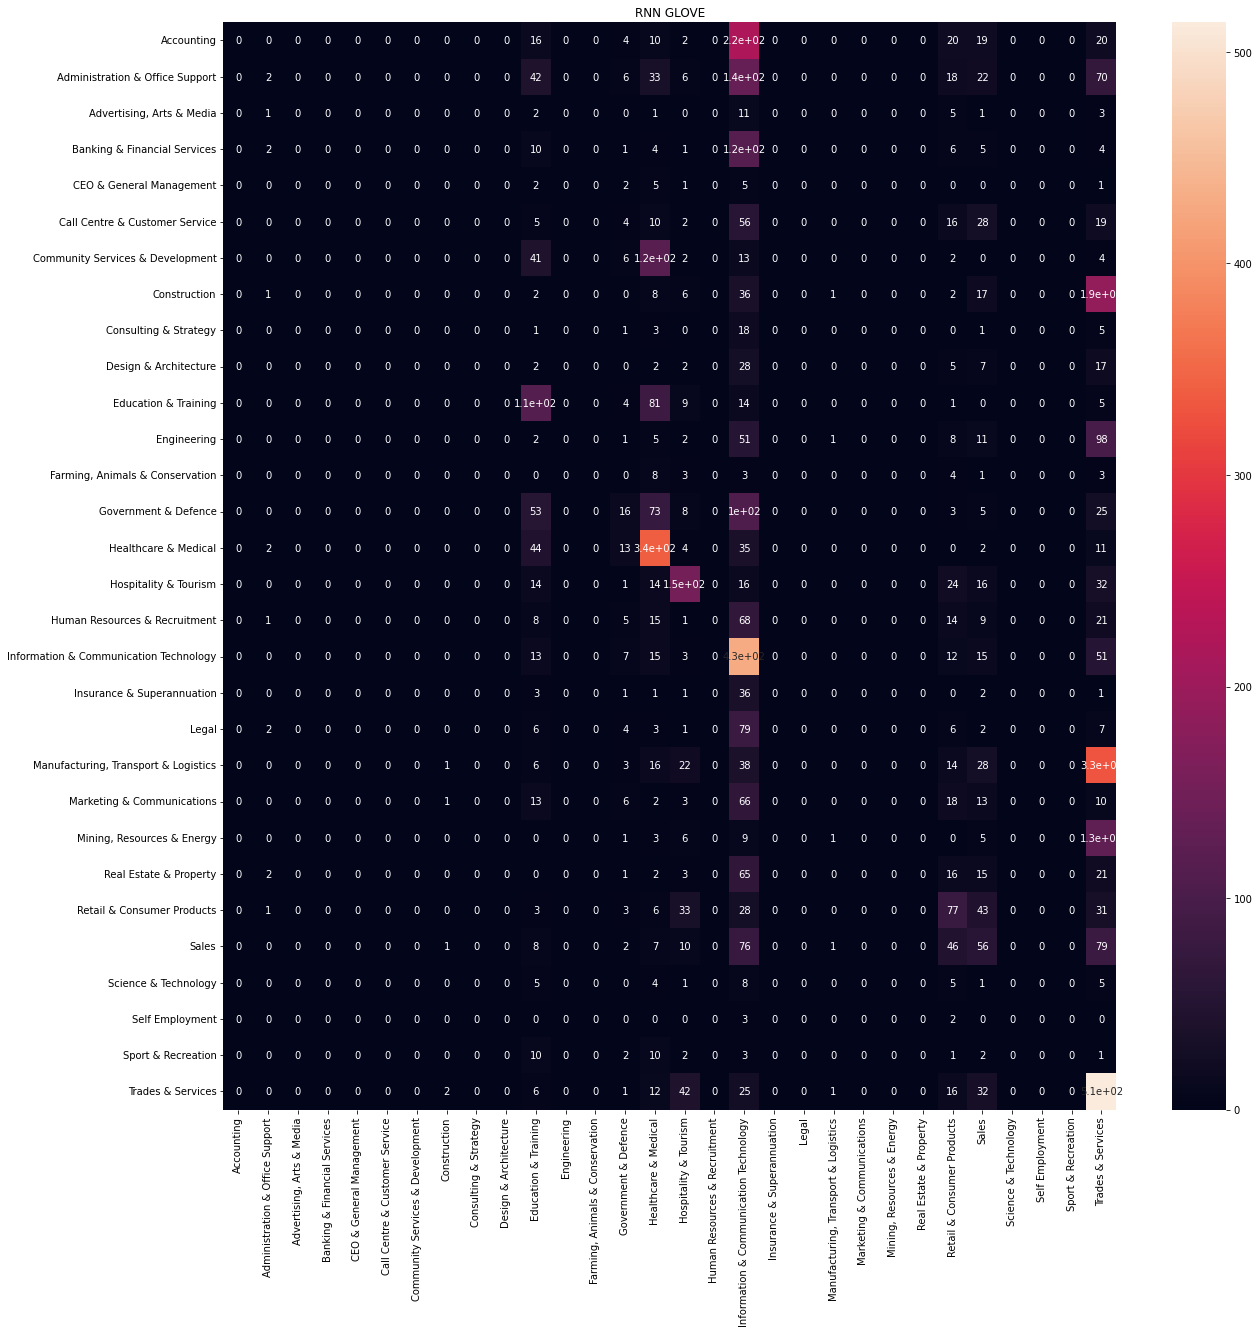

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20,20)) 
sns.heatmap(rnn_glove_conf_mat, annot= True, xticklabels=classnames, yticklabels=classnames )
plt.title("RNN GLOVE")

Text(0.5, 1.0, 'RNN word2vec')

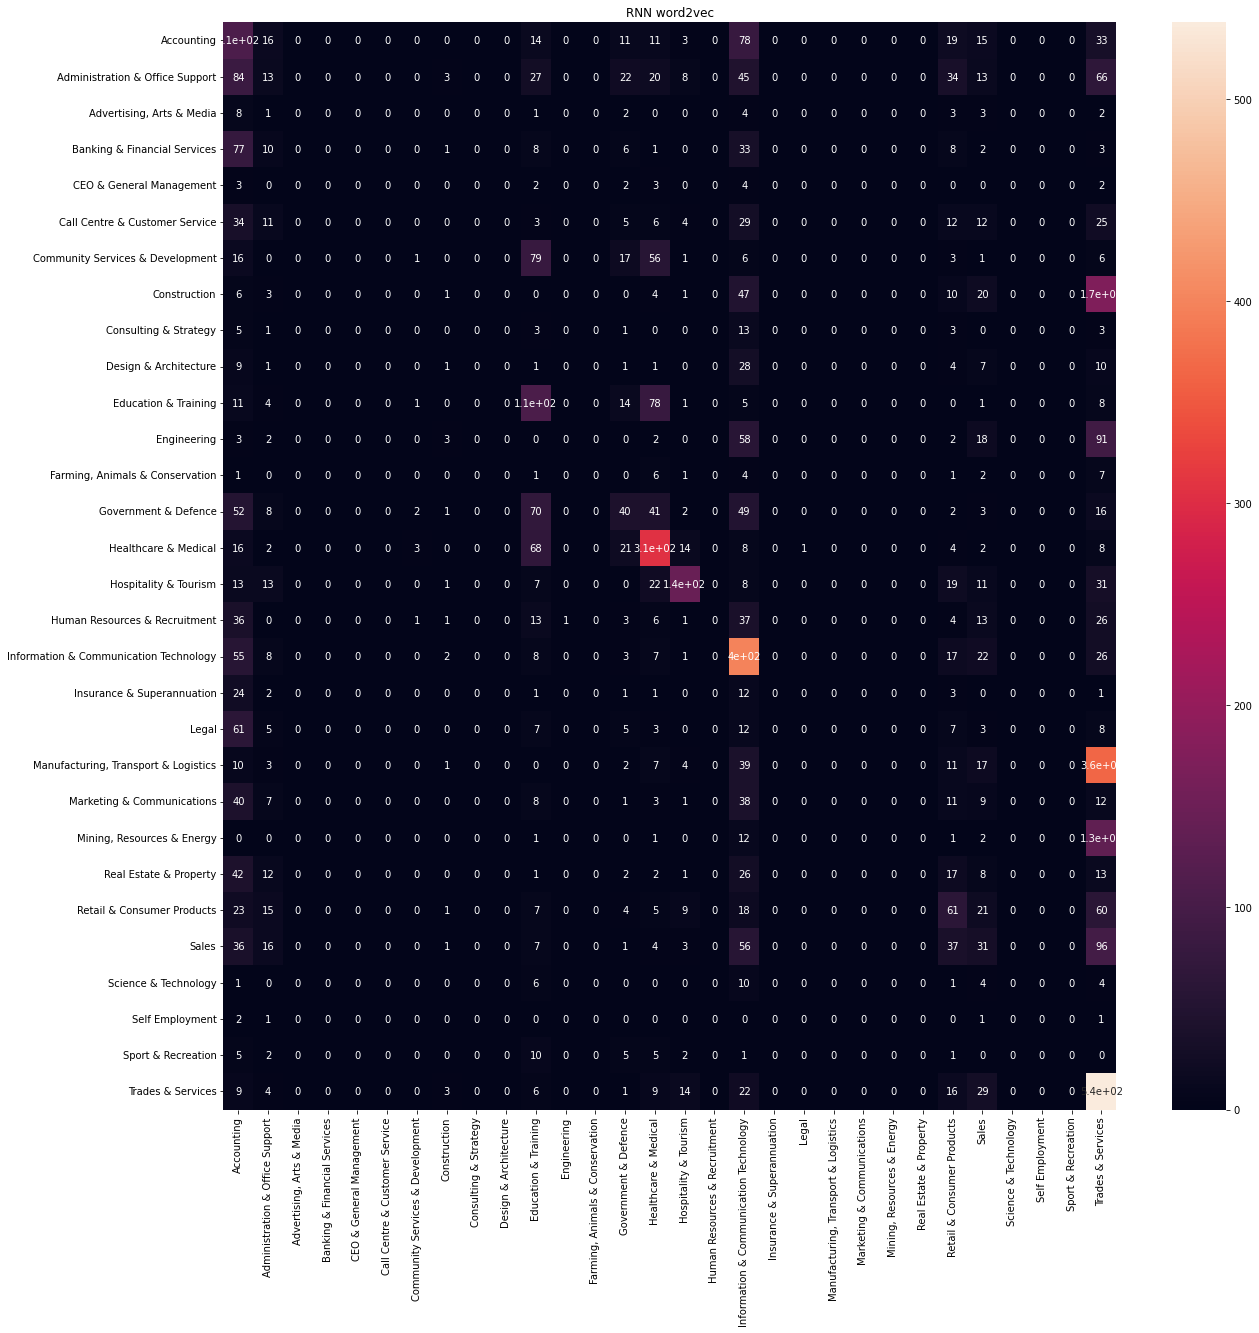

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20,20)) 
sns.heatmap(rnn_word2vec_conf_mat, annot= True, xticklabels=classnames, yticklabels=classnames )
plt.title("RNN word2vec")

Domain-specific RNN manages to identify at least 5 classes compared to pretrained RNN's 4, although the "Trades and service" and "Accounting" classes would have a low precission owing to the fact the the classes have a large portiong of the models' false positives. Meaning, even though it seems to identify these classes, the models tend to classifier most other classes as these two classes. Hence it is unrealiable.

Text(0.5, 1.0, 'Gru glove')

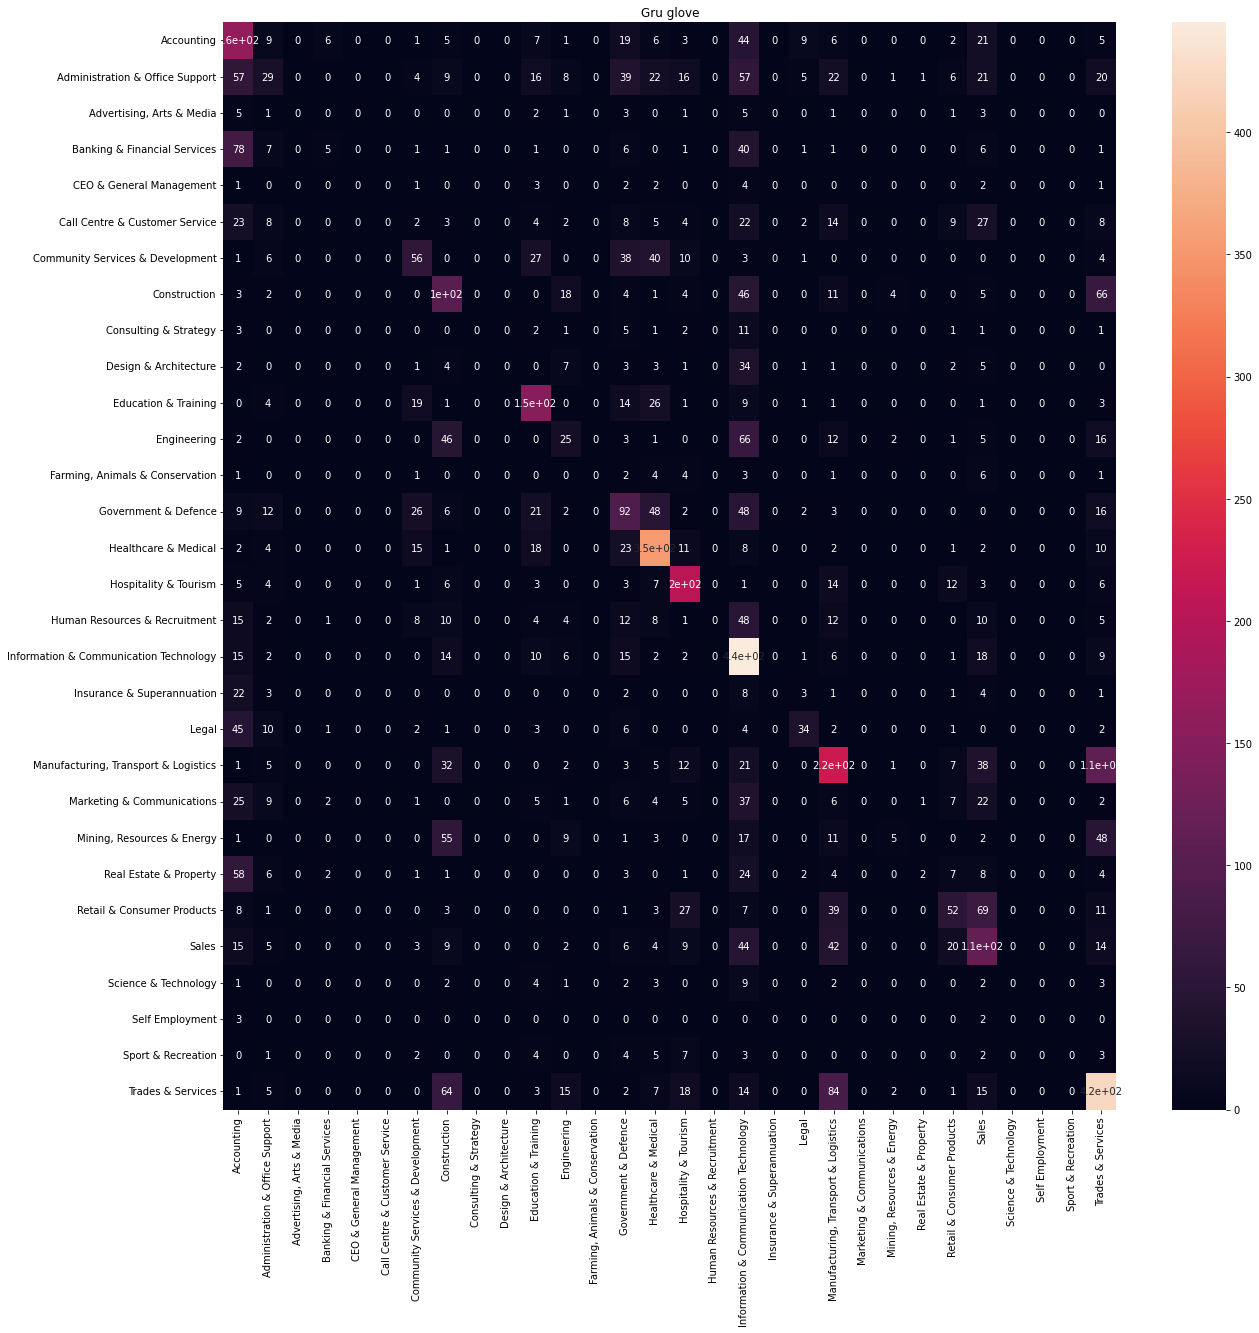

In [59]:
fig, ax = plt.subplots(figsize=(20,20)) 
sns.heatmap(gru_glove_conf_mat, annot= True, xticklabels=classnames, yticklabels=classnames )
plt.title("Gru glove")

Text(0.5, 1.0, 'GRU word2vec')

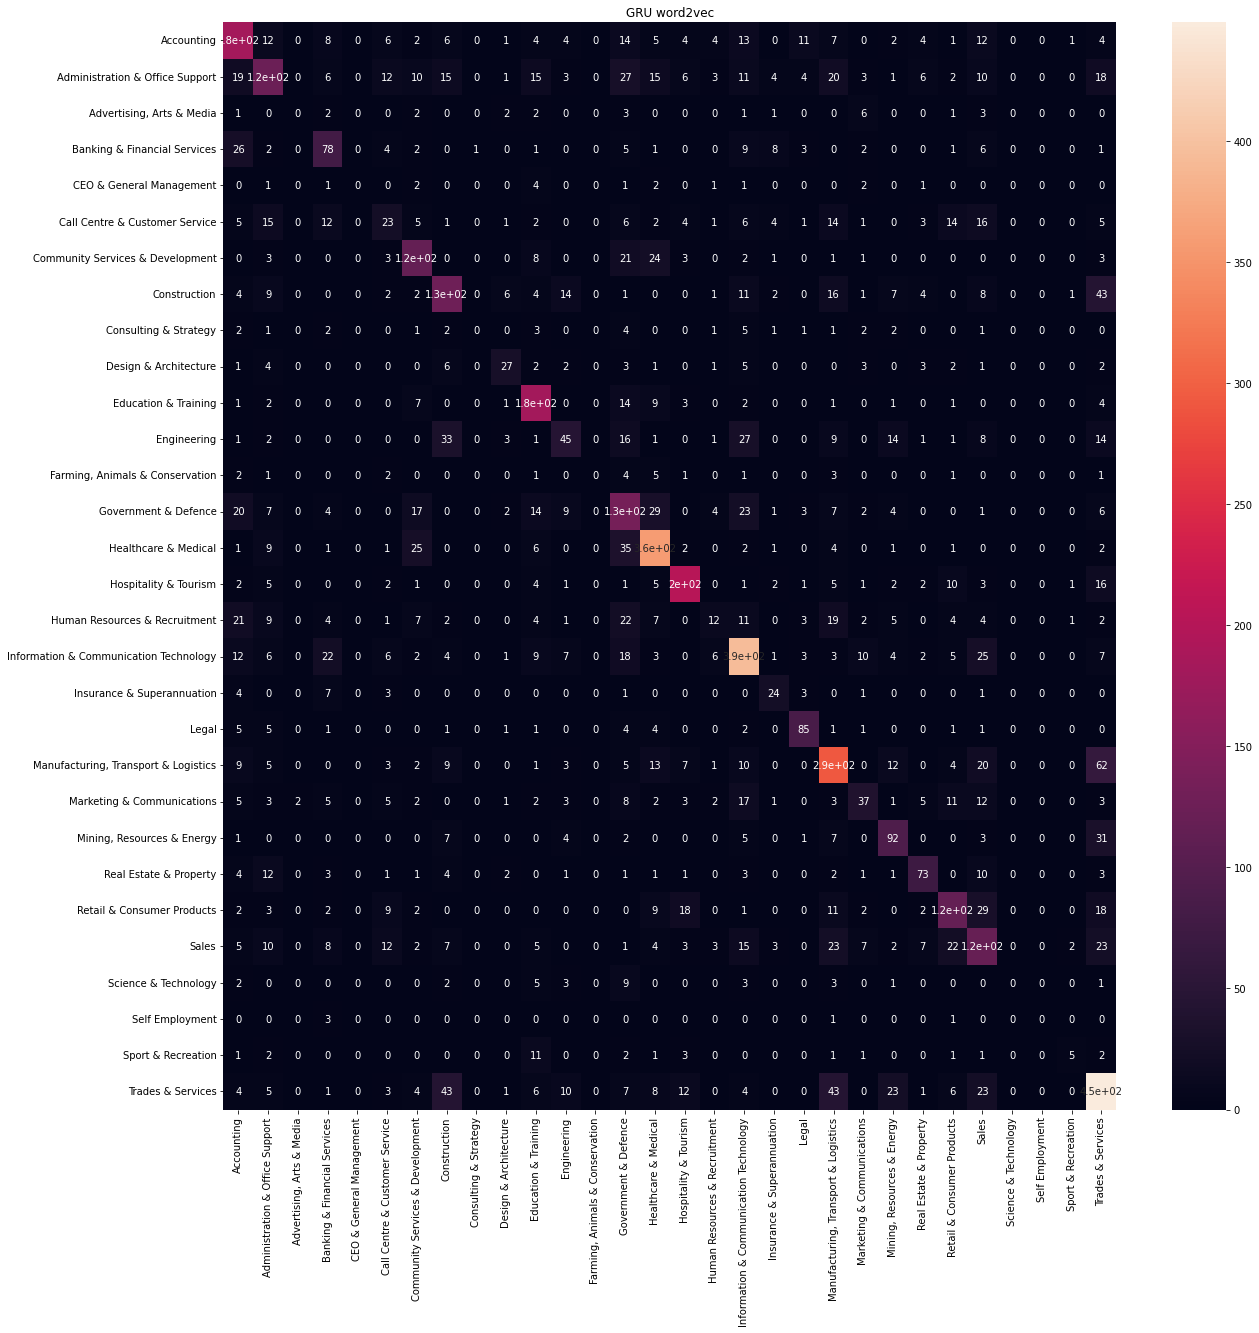

In [58]:
fig, ax = plt.subplots(figsize=(20,20)) 
sns.heatmap(gru_word2vec_conf_mat, annot= True, xticklabels=classnames, yticklabels=classnames )
plt.title("GRU word2vec")